# Imports

In [1]:
## Logging and Shell
import logging

from polymerist.openfftools.partialcharge import molchargers
logging.basicConfig(
    level=logging.ERROR,
    force=True
)

## Generic imports
from typing import Any, Optional
from collections import defaultdict

## Numeric imports
import numpy as np
import pandas as pd

## File I/O
from pathlib import Path
import json, pickle

# Cheminformatics
from rdkit import Chem

from openmm.unit import nanometer, angstrom, Quantity

from openff.toolkit import Molecule, Topology, ForceField
from openff.toolkit.utils.exceptions import (
    UnassignedChemistryInPDBError,
    IncorrectNumConformersWarning,
)

# Custom Imports
from polymerist.genutils.containers import RecursiveDict
from polymerist.genutils.fileutils import filetree
from polymerist.duration import Duration, Timer
from polymerist.unitutils.interop import openmm_to_openff

from polymerist.maths.greek import GREEK_PREFIXES
from polymerist.maths.lattices import generate_int_lattice

from polymerist.rdutils.rdprops import copy_rd_props
from polymerist.rdutils.rdcoords import tiling
from polymerist.rdutils.reactions import reactions, reactors

from polymerist.openfftools.partition import partition
from polymerist.openfftools import topology, boxvectors, FFDIR
from polymerist.monomers import specification, MonomerGroup
from polymerist.polymers import building

# catch annoying warnings
import warnings 
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=IncorrectNumConformersWarning)

# Load monomer and rxn data 

In [2]:
# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')

In [3]:
# input_data_path = PROC_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers_FILTERED.csv'
# input_data_path = PROC_DATA_DIR / 'nipu_urethanes_FILTERED.csv'
input_data_path = PROC_DATA_DIR / 'monomer_data_MASTER.csv'
df = pd.read_csv(input_data_path, index_col=[0,1])
df = df.replace(np.nan, None) # swap NaN values for explicit NoneTypes to simplify value write

In [4]:
# benchsamp = pd.read_csv('oligomers_for_benchmark.csv', index_col=[0,1])
# df = df.loc[benchsamp.index]

## Load pre-defined reactions with functional group and name backmap

In [5]:
take_first_n : Optional[int] = None # debug option to only take a handful of compounds from each family
# take_first_n : Optional[int] = 2
blacklisted_rxns = ['polyimide']#, 'polyvinyl_head_tail']

frames_by_mech : dict[str, pd.DataFrame] = {}
for rxn_name in df.index.unique(level='mechanism'):
    if rxn_name in blacklisted_rxns:
        continue

    rxn_df = df.xs(rxn_name)
    if take_first_n is not None:
        rxn_df = rxn_df.head(take_first_n)
    frames_by_mech[rxn_name] = rxn_df

In [6]:
with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

# Auto-generating monomer fragments and Topologies

## Set up and format progress bars to track build status

In [7]:
from rich.progress import Progress
from rich.progress import (
    BarColumn,
    Progress,
    SpinnerColumn,
    TaskProgressColumn,
    TextColumn,
    TimeElapsedColumn,
    TimeRemainingColumn,
)
from rich.console import Group
from rich.live import Live

# status of individual task
status_readout = Progress(
    'STATUS:',
    TextColumn(
        '[purple]{task.fields[action]}'
    ),
    '...'
)
status_id = status_readout.add_task('[green]Current compound:', action='')

# textual display of the name of the curent polymer
compound_readout = Progress(
    'Current compound:',
    TextColumn(
        '[blue]{task.fields[polymer_name]}',
        justify='right'
    )
)
curr_compound_id  = compound_readout.add_task('[green]Compound:', polymer_name='')

# progress over individual compounds (irrespective of mechanism)
compound_progress = Progress(
    SpinnerColumn(),
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    TextColumn(
        '({task.completed} / {task.total})'
    ),
)
comp_progress_id = compound_progress.add_task('[blue]Unique compound(s)   ', polymer_name='')

# progress over distinct classes of mechanism
inter_mech_progress = Progress(
    SpinnerColumn(),
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    TextColumn(
        '({task.completed} / {task.total})'
    ),
)
curr_mechanism_id = inter_mech_progress.add_task('[blue]Reaction mechanism(s)', start=True, total=len(frames_by_mech))

# individual progress bars for compounds within each mechanism
intra_mech_progress = Progress(
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    TextColumn(
        '({task.completed} / {task.total})'
    ),
    'At:',
    TimeElapsedColumn(),
)
total_compounds = 0
mech_task_ids = {} # preprocess dataframes by mechanism to determine progress bar layout and task lengths
for rxn_name, rxn_df in frames_by_mech.items():
    num_compounds = len(rxn_df)
    mech_task_ids[rxn_name] = intra_mech_progress.add_task(f'[cyan]{rxn_name}', start=True, total=len(rxn_df))
    total_compounds += num_compounds
compound_progress.update(curr_compound_id, total=total_compounds)

# combine progess readouts into unified live console
group = Group(
    status_readout,
    compound_readout,
    compound_progress,
    inter_mech_progress,
    intra_mech_progress,
)

## Define utility functions

In [8]:
import re
from time import sleep, time
from polymerist.rdutils.rdtypes import RDMol


HILL_REGEX = re.compile(r'([A-Z][a-z]?)[0-9]*?') # break apart hill formula into just unique elements (one captial letter, one or no lowercase letters, any (including none) digits)

def generate_smarts_fragments(reactants_dict : dict[str, RDMol], reactor : reactors.PolymerizationReactor) -> MonomerGroup:
    '''Takes a labelled dict of reactant Mols and a PolymerizationReactor object with predefined rxn mechanism
    Returns a MonomerGroup containing all fragments enumerated by the provided rxn'''
    monogrp = MonomerGroup()
    initial_reactants = [reactants for reactants in reactants_dict.values()] # must convert to list to pass to ChemicalReaction
    
    for intermediates, frags in reactor.propagate(initial_reactants):
        for assoc_group_name, rdfragment in zip(reactants_dict.keys(), frags):
            # generate spec-compliant SMARTS
            raw_smiles = Chem.MolToSmiles(rdfragment)
            exp_smiles = specification.expanded_SMILES(raw_smiles)
            spec_smarts = specification.compliant_mol_SMARTS(exp_smiles)

            # record to monomer group
            affix = 'TERM' if MonomerGroup.is_terminal(rdfragment) else 'MID'
            monogrp.monomers[f'{assoc_group_name}_{affix}'] = [spec_smarts]

    return monogrp

## Set parameters for build process

In [9]:
MASTER_OUT_DIR = Path('polymer_improved')

DOPs : list[int] = [3]
charge_method : str = 'Espaloma-AM1-BCC'
force_field_name : str = 'openff_unconstrained-2.0.0.offxml' # 'openff-2.0.0.offxml'

lattice_sizes : list[np.ndarray] = [
    np.array([1, 1, 1]), # just a single molecule in a box
    np.array([2, 2, 2]),
    np.array([3, 3, 3]),
    np.array([5, 5, 5]),
]

switching_function : bool = False
exclusion : Quantity = 0.0 * nanometer 
nonbond_cutoff : Quantity = 0.9 * nanometer

clear_existing           : bool = True#False
refragment               : bool = False  
repolymerize_pdbs        : bool = False
reparameterize           : bool = False
reassign_partial_charges : bool = False
perform_energy_min       : bool = True

# preprocess parameters
charger = molchargers.MolCharger.subclass_registry[charge_method]()
lattices = {
    'x'.join(str(i) for i in lattice_size) : generate_int_lattice(*lattice_size)
        for lattice_size in lattice_sizes
}
forcefield = ForceField(FFDIR / force_field_name)

min_box_dim : Quantity = 2 * nonbond_cutoff # should be at least twice the nonbonded cutoff to avoid self-interaction
min_bbox = openmm_to_openff(min_box_dim * np.eye(3))

## Execute build loop

In [10]:
# create directories
MASTER_OUT_DIR.mkdir(exist_ok=True)
if clear_existing:
    filetree.clear_dir(MASTER_OUT_DIR)

# set up data structures for global output
failure_record = RecursiveDict()
m2p_mismatches = RecursiveDict()

# execute build loop
num_successful : int = 0
md_build_records : list[dict[str, Any]] = []
with Live(group, refresh_per_second=10) as live:
    # ensure bars start at 0
    for pbar in group.renderables: 
        for task_id in pbar.task_ids:
            pbar.reset(task_id)

    # iterate over all distinct chemistries by reaction mechanism
    for rxn_name, rxn_df in frames_by_mech.items():
        # look up reactive groups and pathway by mechanism
        mech_task_id = mech_task_ids[rxn_name]
        rxn_pathway  = rxns[rxn_name]
        reactor = reactors.PolymerizationReactor(rxn_pathway)
        
        # initialize output directories
        mech_dir : Path = MASTER_OUT_DIR / rxn_name
        mech_dir.mkdir(exist_ok=True)

        for (polymer_name, row) in rxn_df.iterrows():
            compound_readout.update(curr_compound_id, polymer_name=polymer_name)
            chem_dir : Path = mech_dir / polymer_name
            chem_dir.mkdir(exist_ok=True)

            # 0) load reactants with IUPAC names from chemical table
            status_readout.update(status_id, action='Gathering reactants')
            named_reactants = {}
            for j in range(2):
                reactant = Chem.MolFromSmiles(row[f'smiles_monomer_{j}'], sanitize=False)
                Chem.SanitizeMol(reactant, sanitizeOps=specification.SANITIZE_AS_KEKULE)
                named_reactants[ row[f'IUPAC_name_monomer_{j}'] ] = reactant

            try:
                # 1) use rxn template to polymerize monomers into all possible fragments
                frag_path = chem_dir / f'{polymer_name}.json'
                if frag_path.exists() and not refragment: # if fragments have already been 
                    status_readout.update(status_id, action='Loading pre-existing monomer fragments')
                    monogrp = MonomerGroup.from_file(frag_path)
                else:
                    status_readout.update(status_id, action='Generating monomer fragments via reaction mechanism')
                    monogrp = generate_smarts_fragments(named_reactants, reactor=reactor)

                    status_readout.update(status_id, action='Saving monomer fragments...')
                    monogrp.to_file(frag_path)

                for dop in DOPs:
                    nmer_name = f'{GREEK_PREFIXES[dop]}mer'
                    dop_dir : Path = chem_dir / nmer_name
                    dop_dir.mkdir(exist_ok=True)

                    # 2) Generate PDB file for linear chain from fragments
                    pdb_path : Path = dop_dir / f'{polymer_name}.pdb'
                    if not pdb_path.exists() or repolymerize_pdbs:
                        status_readout.update(status_id, action=f'Generating PDB file (with{"" if perform_energy_min else "out"} UFF energy minimization)')
                        polymer = building.build_linear_polymer(monomers=monogrp, DOP=dop+1, sequence='BA', energy_minimize=perform_energy_min)  # "BA" is needed to make term groups align properly, DOP does not account for term group pair (hence the "+1")
                        building.mbmol_to_openmm_pdb(pdb_path, polymer)
                        
                        # checking that my method produces the same results as M2P
                        m2p_smiles = row.smiles_polymer_DP6
                        if m2p_smiles is not None:
                            m2p_mol = Chem.MolFromSmiles(m2p_smiles)
                            workflow_smiles = polymer.to_smiles()
                            workflow_mol    = Chem.MolFromSmiles(workflow_smiles)

                            if not (workflow_mol.HasSubstructMatch(m2p_mol) or m2p_mol.HasSubstructMatch(workflow_mol)):
                                m2p_mismatches[rxn_name][polymer_name]['M2P_vers'] = m2p_smiles
                                m2p_mismatches[rxn_name][polymer_name]['workflow_vers'] = workflow_smiles

                    # 3a) Assign chemical info to PDB system
                    param_top_path = dop_dir / f'{polymer_name}.sdf'
                    if param_top_path.exists() and not reparameterize:
                        status_readout.update(status_id, action='Loading parameterized single-mol Topology')
                        offtop = topology.topology_from_sdf(param_top_path)
                    else:
                        try:
                            status_readout.update(status_id, action='Partitioning topology by fragments')
                            offtop = Topology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
                            assert(partition(offtop)) # verify that a partition was possible
                            topology.topology_to_sdf(param_top_path, offtop)
                        except UnassignedChemistryInPDBError:
                            failure_record['No substruct cover'][rxn_name][polymer_name][dop] = monogrp
                            continue # skip to next compounds, don't proceed with parameterization   
                        except AssertionError:
                            failure_record['No substruct partition'][rxn_name][polymer_name][dop] = monogrp
                            continue # skip to next compounds, don't proceed with parameterization   

                    offmol = topology.get_largest_offmol(offtop)
                    offmol.name = polymer_name

                    # 3b) Assign partial charges, if not already present
                    if not molchargers.has_partial_charges(offmol):
                        status_readout.update(status_id, action=f'Assigning partial charges via {charger.CHARGING_METHOD}')
                        cmol = charger.charge_molecule(offmol)
                        unique_elems = re.findall(HILL_REGEX, cmol.hill_formula) # unique element names in same order as found in Hill formula
                    
                    # generate tiled lattices as specified
                    for lattice_str, lattice in lattices.items(): # NOTE : key that this is done AFTER parameterization to avoid reassigning parameters to a (potentially) much larger Topology
                        latt_dir : Path = dop_dir / lattice_str
                        latt_dir.mkdir(exist_ok=True)

                        # create tiled version of parameterized topology
                        with Timer() as topo_timer:
                            status_readout.update(status_id, action=f'Generating tiled {lattice_str} topology')
                            tiled_offtop = topology.topology_from_molecule_onto_lattice(cmol, lattice=lattice, rotate_randomly=True, unique_mol_ids=True)
                            latt_top_path = latt_dir / f'{lattice_str}_{polymer_name}.sdf'
                            topology.topology_to_sdf(latt_top_path, tiled_offtop)

                        # generate appropriately-sized periodic box size, starting with the tight bounding box for the topology
                        top_box_vectors = boxvectors.get_topology_bbox(tiled_offtop) # determine tight box size
                        top_box_vectors = boxvectors.pad_box_vectors_uniform(top_box_vectors, exclusion) # apply periodic box (with padding) to Interchange
                        top_box_vectors = np.maximum(min_bbox, top_box_vectors) # enusre the box is no smaller than the minimum determined by the cutoff distance

                        # create and save Interchange for MD export
                        with Timer() as inc_timer:
                            status_readout.update(status_id, action=f'Creating {lattice_str} OpenFF Interchange')
                            interchange = forcefield.create_interchange(tiled_offtop, charge_from_molecules=[cmol])
                            interchange.box = top_box_vectors # apply periodic box to Interchange

                            # configure nonbonded in Interchange to have correct cutoff and switching function width
                            interchange['vdW'].switch_width = (1.0 if switching_function else 0.0) * angstrom
                            interchange['vdW'           ].cutoff = nonbond_cutoff
                            interchange['Electrostatics'].cutoff = nonbond_cutoff

                        latt_inc_path = latt_dir / f'{lattice_str}_{polymer_name}.pkl'
                        with latt_inc_path.open('wb') as pklfile: # NOTE: pickled files must be read/written in binary mode
                            pickle.dump(interchange, pklfile)

                        # record information about MD build run to simplfiy resuming, analyzing, and benchmarking structure outputs
                        md_build_entry = {
                            'mechanism'                : rxn_name,
                            'polymer_name'             : polymer_name,
                            'exper_density'            : row['Density'],
                            'lattice_size'             : lattice_str,
                            'oligomer_type'            : nmer_name,
                            'n_atoms_in_topology'      : tiled_offtop.n_atoms,
                            'unique_elems_in_topology' : unique_elems, 
                            'directory'                : str(latt_dir),
                            'topology_path'            : str(latt_top_path),
                            'topology_time'            : topo_timer.time_taken,
                            'interchange_path'         : str(latt_inc_path),
                            'interchange_time'         : inc_timer.time_taken,
                        }
                        md_build_records.append(md_build_entry)

                        md_build_entry_path = latt_dir / f'{lattice_str}_{nmer_name}_{polymer_name}_RECORD.json'
                        with md_build_entry_path.open('w') as record_file: # also save to disc individually, to allow reconstruction if loop fails haflway through
                            json.dump(md_build_entry, record_file, indent=4)
                    
                num_successful += 1

            except Exception as other_error:
                failure_record[other_error.__class__.__name__][rxn_name][polymer_name] = str(other_error)
            finally:
                intra_mech_progress.advance(mech_task_id)
                compound_progress.advance(comp_progress_id)
                
        inter_mech_progress.advance(curr_mechanism_id, advance=1)
        sleep(0.1) # needed to give final bar enough time to catch up
    compound_readout.update(curr_compound_id, polymer_name=f'Completed! ({num_successful}/{total_compounds} successful)')

all_records_path = MASTER_OUT_DIR / 'build_records.csv'
md_build_records_table = pd.DataFrame.from_records(md_build_records)
md_build_records_table.set_index(['mechanism', 'polymer_name'], inplace=True)
md_build_records_table.to_csv(all_records_path)

m2p_mismatch_path = MASTER_OUT_DIR / 'm2p_mismatches.json'
with m2p_mismatch_path.open('w') as m2p_mismatch_file:
    json.dump(m2p_mismatches, m2p_mismatch_file, indent=4)

print(failure_record)
print(m2p_mismatches)

Output()

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/compound.py:2888: UserWarning: 
Performing energy minimization using the Open Babel package. Please refer to the documentation to find the 
appropriate citations for Open Babel and the UFF force field
  warn(

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/conversion.py:1849: UserWarning: 
The bond orders will be guessed using pybelOBMol.PerceviedBondOrders()
  warn(

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/dgl/heterograph.py:92: DGLWarning: 
Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(

[00:44:03] Explicit valence for atom # 19 N, 4, is greater than permitted

RecursiveDict(<class 'polymerist.genutils.containers.RecursiveDict'>,
              {'AtomValenceException': RecursiveDict(<class 'polymerist.genutils.containers.RecursiveDict'>,
                                                     {'polyurethane_isocyanate': RecursiveDict(<class 'polymerist.genutils.containers.RecursiveDict'>,
                                                                                               {'poly(1-isocyanato-4-[(4-isocyanatophenyl)methyl]benzene-co-2-[2-hydroxyethyl-[4-(4-nitrophenyl)diazenylphenyl]amino]ethanol)': 'Explicit '
                                                                                                                                                                                                                                'valence '
                                                                                                                                                                                                       

In [20]:
help(Chem.RemoveStereochemistry)

Help on built-in function RemoveStereochemistry in module rdkit.Chem.rdmolops:

RemoveStereochemistry(...)
    RemoveStereochemistry( (Mol)mol) -> None :
        Removes all stereochemistry info from the molecule.
        
        
    
        C++ signature :
            void RemoveStereochemistry(RDKit::ROMol {lvalue})



polyamide
	 poly(4-[2-(4-aminophenyl)-1,1,1,3,3,3-hexafluoropropan-2-yl]aniline-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2h-indene-5-carboxylic acid)
		 M2P_vers
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(C(c4ccc(NC(=O)c5ccc6c(c5)C(C)(C)CC6(C)c5ccc(C(=O)Nc6ccc(C(c7ccc(NC(=O)c8ccc(C9(C)CC(C)(C)c%10cc(C(=O)Nc%11ccc(C(c%12ccc(N)cc%12)(C(F)(F)F)C(F)(F)F)cc%11)ccc%109)cc8)cc7)(C(F)(F)F)C(F)(F)F)cc6)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccc(C(=O)O)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(C(c4ccc(NC(=O)c5ccc6c(c5)C(C)(C)CC6(C)c5ccc(C(=O)Nc6ccc(C(c7ccc(NC(=O)c8ccc(C9(C)CC(C)(C)c%10cc(C(=O)Nc%11ccc(C(c%12ccc(N)cc%12)(C(F)(F)F)C(F)(F)F)cc%11)ccc%109)cc8)cc7)(C(F)(F)F)C(F)(F)F)cc6)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccc(C(=O)O)cc21


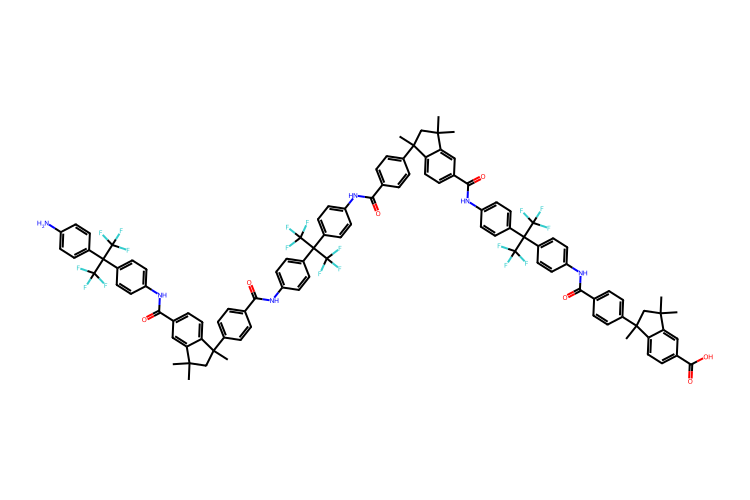

		 workflow_vers
CC1(C)C[C@@](C)(c2ccc(C(=O)Nc3ccc(C(c4ccc(N)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccc(C(=O)Nc3ccc(C(c4ccc(NC(=O)c5ccc([C@]6(C)CC(C)(C)c7cc(C(=O)Nc8ccc(C(c9ccc(NC(=O)c%10ccc([C@@]%11(C)CC(C)(C)c%12cc(C(=O)O)ccc%12%11)cc%10)cc9)(C(F)(F)F)C(F)(F)F)cc8)ccc76)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(C(c4ccc(NC(=O)c5ccc6c(c5)C(C)(C)CC6(C)c5ccc(C(=O)Nc6ccc(C(c7ccc(NC(=O)c8ccc9c(c8)C(C)(C)CC9(C)c8ccc(C(=O)Nc9ccc(C(c%10ccc(N)cc%10)(C(F)(F)F)C(F)(F)F)cc9)cc8)cc7)(C(F)(F)F)C(F)(F)F)cc6)cc5)cc4)(C(F)(F)F)C(F)(F)F)cc3)cc2)c2ccc(C(=O)O)cc21


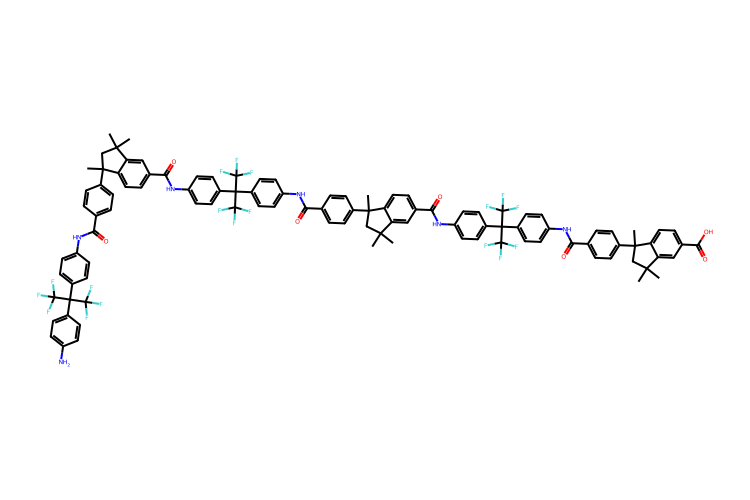

False
	 poly(4-[4-[2-[4-(4-aminophenoxy)phenyl]propan-2-yl]phenoxy]aniline-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2h-indene-5-carboxylic acid)
		 M2P_vers
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc(NC(=O)c7ccc(C8(C)CC(C)(C)c9cc(C(=O)Nc%10ccc(Oc%11ccc(C(C)(C)c%12ccc(Oc%13ccc(NC(=O)c%14ccc%15c(c%14)C(C)(C)CC%15(C)c%14ccc(C(=O)Nc%15ccc(Oc%16ccc(C(C)(C)c%17ccc(Oc%18ccc(N)cc%18)cc%17)cc%16)cc%15)cc%14)cc%13)cc%12)cc%11)cc%10)ccc98)cc7)cc6)cc5)cc4)cc3)cc2)c2ccc(C(=O)O)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc(NC(=O)c7ccc(C8(C)CC(C)(C)c9cc(C(=O)Nc%10ccc(Oc%11ccc(C(C)(C)c%12ccc(Oc%13ccc(NC(=O)c%14ccc%15c(c%14)C(C)(C)CC%15(C)c%14ccc(C(=O)Nc%15ccc(Oc%16ccc(C(C)(C)c%17ccc(Oc%18ccc(N)cc%18)cc%17)cc%16)cc%15)cc%14)cc%13)cc%12)cc%11)cc%10)ccc98)cc7)cc6)cc5)cc4)cc3)cc2)c2ccc(C(=O)O)cc21


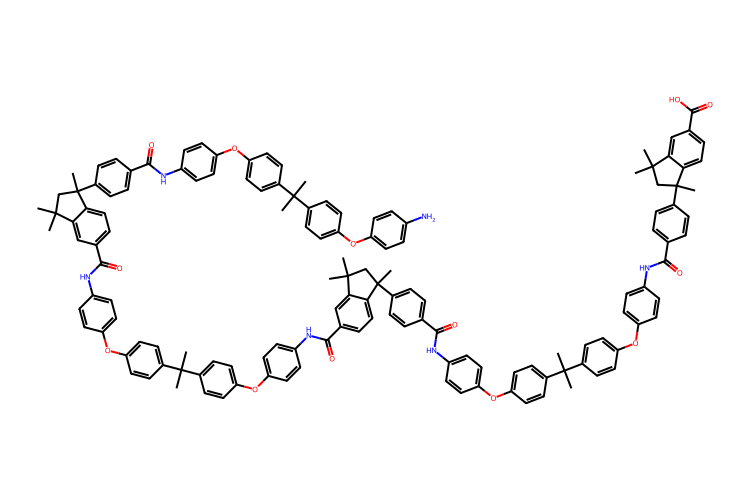

		 workflow_vers
CC1(C)C[C@@](C)(c2ccc(C(=O)Nc3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc(N)cc6)cc5)cc4)cc3)cc2)c2ccc(C(=O)Nc3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc(NC(=O)c7ccc([C@@]8(C)CC(C)(C)c9cc(C(=O)Nc%10ccc(Oc%11ccc(C(C)(C)c%12ccc(Oc%13ccc(NC(=O)c%14ccc([C@@]%15(C)CC(C)(C)c%16cc(C(=O)O)ccc%16%15)cc%14)cc%13)cc%12)cc%11)cc%10)ccc98)cc7)cc6)cc5)cc4)cc3)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6ccc(NC(=O)c7ccc8c(c7)C(C)(C)CC8(C)c7ccc(C(=O)Nc8ccc(Oc9ccc(C(C)(C)c%10ccc(Oc%11ccc(NC(=O)c%12ccc%13c(c%12)C(C)(C)CC%13(C)c%12ccc(C(=O)Nc%13ccc(Oc%14ccc(C(C)(C)c%15ccc(Oc%16ccc(N)cc%16)cc%15)cc%14)cc%13)cc%12)cc%11)cc%10)cc9)cc8)cc7)cc6)cc5)cc4)cc3)cc2)c2ccc(C(=O)O)cc21


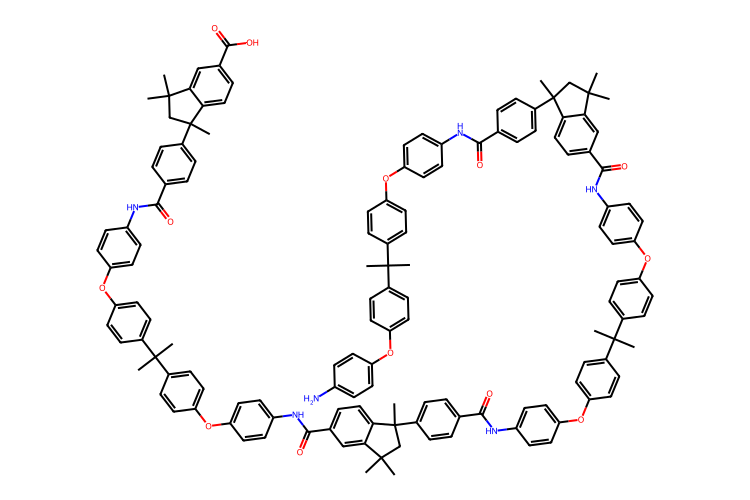

False
	 poly(4-(4-amino-2-methylphenyl)-3-methylaniline-co-5-(3-carboxy-4-methoxycarbonylbenzoyl)-2-methoxycarbonylbenzoic acid)
		 M2P_vers
COC(=O)c1ccc(C(=O)c2ccc(C(=O)OC)c(C(=O)Nc3ccc(-c4ccc(NC(=O)c5cc(C(=O)c6ccc(C(=O)OC)c(C(=O)Nc7ccc(-c8ccc(NC(=O)c9cc(C(=O)c%10ccc(C(=O)OC)c(C(=O)Nc%11ccc(-c%12ccc(N)cc%12C)c(C)c%11)c%10)ccc9C(=O)OC)cc8C)c(C)c7)c6)ccc5C(=O)OC)cc4C)c(C)c3)c2)cc1C(=O)O
COC(=O)c1ccc(C(=O)c2ccc(C(=O)OC)c(C(=O)Nc3ccc(-c4ccc(NC(=O)c5cc(C(=O)c6ccc(C(=O)OC)c(C(=O)Nc7ccc(-c8ccc(NC(=O)c9cc(C(=O)c%10ccc(C(=O)OC)c(C(=O)Nc%11ccc(-c%12ccc(N)cc%12C)c(C)c%11)c%10)ccc9C(=O)OC)cc8C)c(C)c7)c6)ccc5C(=O)OC)cc4C)c(C)c3)c2)cc1C(=O)O


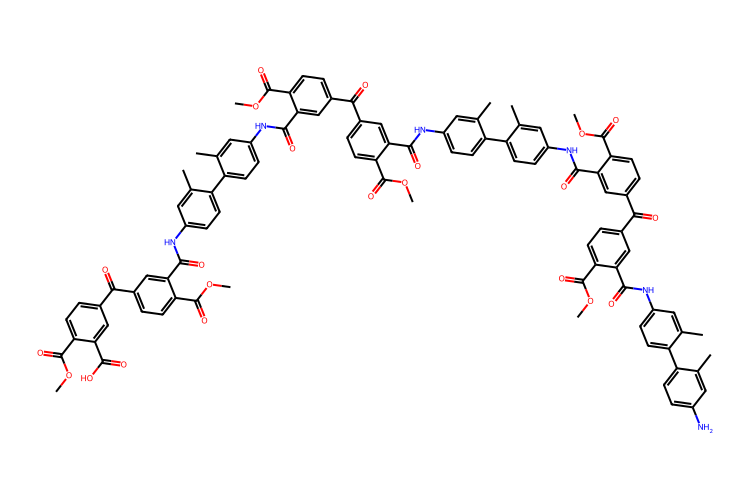

		 workflow_vers
COC(=O)c1ccc([C]([O])c2ccc(C(=O)OC)c(C(=O)Nc3ccc(-c4ccc(NC(=O)c5cc([C]([O])c6ccc(C(=O)OC)c(C(=O)Nc7ccc(-c8ccc(NC(=O)c9cc([C]([O])c%10ccc(C(=O)OC)c(C(=O)Nc%11ccc(-c%12ccc(N)cc%12C)c(C)c%11)c%10)ccc9C(=O)OC)cc8C)c(C)c7)c6)ccc5C(=O)OC)cc4C)c(C)c3)c2)cc1C(=O)O
COC(=O)c1ccc(C(O)c2ccc(C(=O)OC)c(C(=O)Nc3ccc(c4ccc(NC(=O)c5cc(C(O)c6ccc(C(=O)OC)c(C(=O)Nc7ccc(c8ccc(NC(=O)c9cc(C(O)c%10ccc(C(=O)OC)c(C(=O)Nc%11ccc(c%12ccc(N)cc%12C)c(C)c%11)c%10)ccc9C(=O)OC)cc8C)c(C)c7)c6)ccc5C(=O)OC)cc4C)c(C)c3)c2)cc1C(=O)O


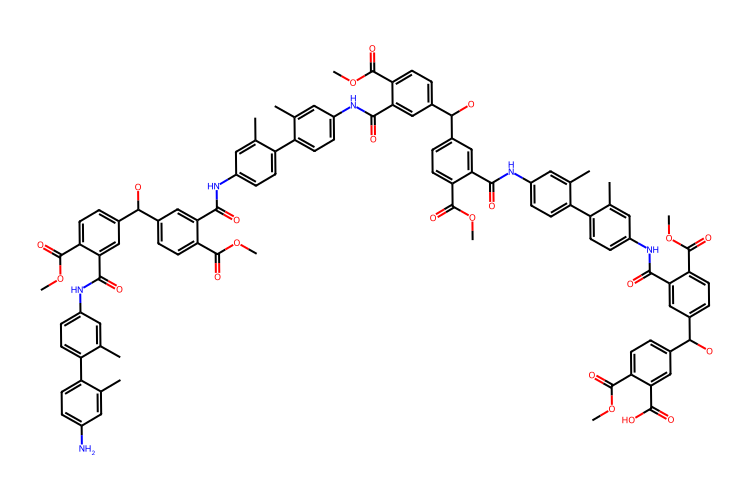

False
	 poly(1,5-bis(3-aminophenyl)penta-1,4-dien-3-one-co-benzene-1,3-dicarboxylic acid)
		 M2P_vers
Nc1cccc(C=CC(=O)C=Cc2cccc(NC(=O)c3cccc(C(=O)Nc4cccc(C=CC(=O)C=Cc5cccc(NC(=O)c6cccc(C(=O)Nc7cccc(C=CC(=O)C=Cc8cccc(NC(=O)c9cccc(C(=O)O)c9)c8)c7)c6)c5)c4)c3)c2)c1
Nc1cccc(C=CC(=O)C=Cc2cccc(NC(=O)c3cccc(C(=O)Nc4cccc(C=CC(=O)C=Cc5cccc(NC(=O)c6cccc(C(=O)Nc7cccc(C=CC(=O)C=Cc8cccc(NC(=O)c9cccc(C(=O)O)c9)c8)c7)c6)c5)c4)c3)c2)c1


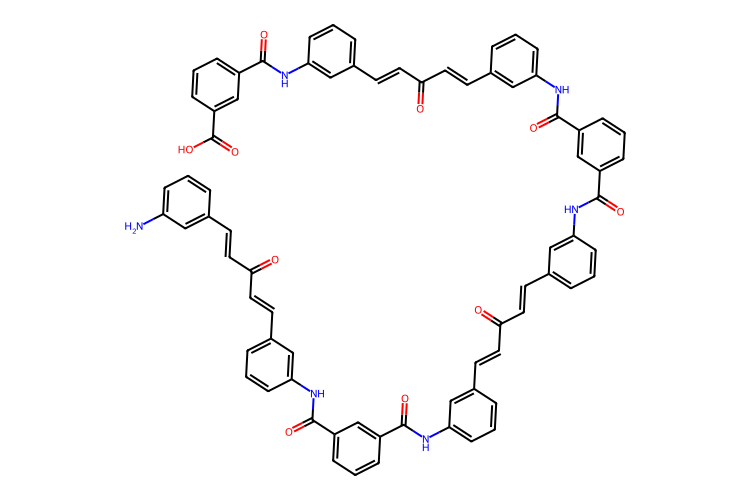

		 workflow_vers
Nc1cccc(C=CC(=O)/C=C/c2cccc(NC(=O)c3cccc(C(=O)Nc4cccc(C=CC(=O)/C=C\c5cccc(NC(=O)c6cccc(C(=O)Nc7cccc(C=C[C]([O])C=Cc8cccc(NC(=O)c9cccc(C(=O)O)c9)c8)c7)c6)c5)c4)c3)c2)c1
Nc1cccc(C=CC(=O)C=Cc2cccc(NC(=O)c3cccc(C(=O)Nc4cccc(C=CC(=O)C=Cc5cccc(NC(=O)c6cccc(C(=O)Nc7cccc(C=CC(O)C=Cc8cccc(NC(=O)c9cccc(C(=O)O)c9)c8)c7)c6)c5)c4)c3)c2)c1


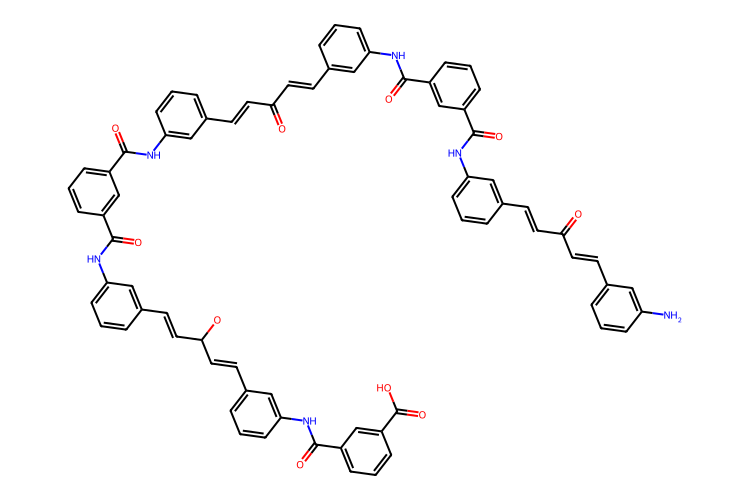

False
	 poly(naphthalene-1,5-diamine-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2h-indene-5-carboxylic acid)
		 M2P_vers
CC1(C)CC(C)(c2ccc(C(=O)O)cc2)c2ccc(C(=O)Nc3cccc4c(NC(=O)c5ccc(C6(C)CC(C)(C)c7cc(C(=O)Nc8cccc9c(NC(=O)c%10ccc%11c(c%10)C(C)(C)CC%11(C)c%10ccc(C(=O)Nc%11cccc%12c(N)cccc%11%12)cc%10)cccc89)ccc76)cc5)cccc34)cc21
CC1(C)CC(C)(c2ccc(C(=O)O)cc2)c2ccc(C(=O)Nc3cccc4c(NC(=O)c5ccc(C6(C)CC(C)(C)c7cc(C(=O)Nc8cccc9c(NC(=O)c%10ccc%11c(c%10)C(C)(C)CC%11(C)c%10ccc(C(=O)Nc%11cccc%12c(N)cccc%11%12)cc%10)cccc89)ccc76)cc5)cccc34)cc21


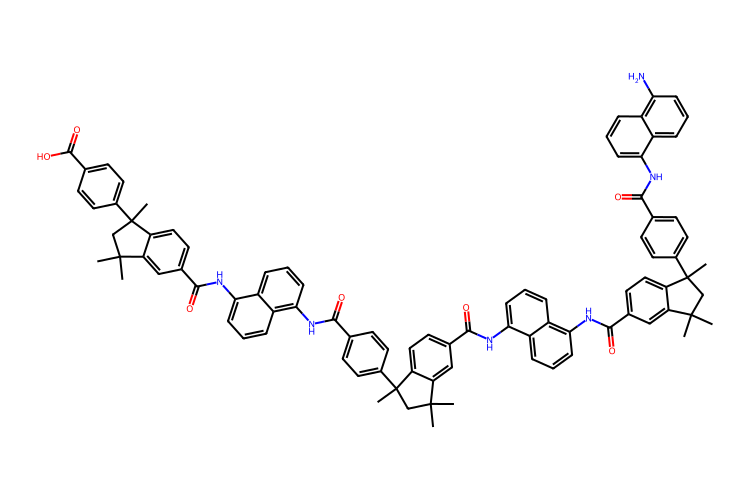

		 workflow_vers
CC1(C)C[C@@](C)(c2ccc(C(=O)Nc3cccc4c(NC(=O)c5ccc6c(c5)C(C)(C)C[C@@]6(C)c5ccc(C(=O)Nc6cccc7c(NC(=O)c8ccc9c(c8)C(C)(C)C[C@]9(C)c8ccc(C(=O)Nc9cccc%10c(N)cccc9%10)cc8)cccc67)cc5)cccc34)cc2)c2ccc(C(=O)O)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3cccc4c(NC(=O)c5ccc6c(c5)C(C)(C)CC6(C)c5ccc(C(=O)Nc6cccc7c(NC(=O)c8ccc9c(c8)C(C)(C)CC9(C)c8ccc(C(=O)Nc9cccc%10c(N)cccc9%10)cc8)cccc67)cc5)cccc34)cc2)c2ccc(C(=O)O)cc21


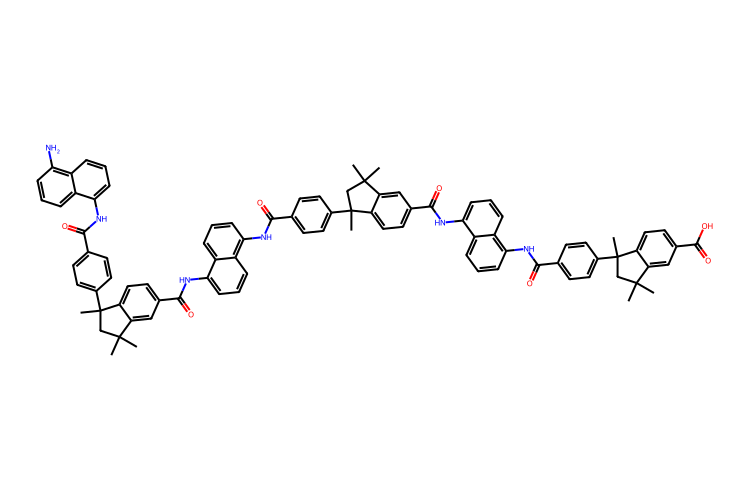

False
	 poly(4-(4-aminophenoxy)aniline-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2h-indene-5-carboxylic acid)
		 M2P_vers
CC1(C)CC(C)(c2ccc(C(=O)O)cc2)c2ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc(C6(C)CC(C)(C)c7cc(C(=O)Nc8ccc(Oc9ccc(NC(=O)c%10ccc(C%11(C)CC(C)(C)c%12cc(C(=O)Nc%13ccc(Oc%14ccc(N)cc%14)cc%13)ccc%12%11)cc%10)cc9)cc8)ccc76)cc5)cc4)cc3)cc21
CC1(C)CC(C)(c2ccc(C(=O)O)cc2)c2ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc(C6(C)CC(C)(C)c7cc(C(=O)Nc8ccc(Oc9ccc(NC(=O)c%10ccc(C%11(C)CC(C)(C)c%12cc(C(=O)Nc%13ccc(Oc%14ccc(N)cc%14)cc%13)ccc%12%11)cc%10)cc9)cc8)ccc76)cc5)cc4)cc3)cc21


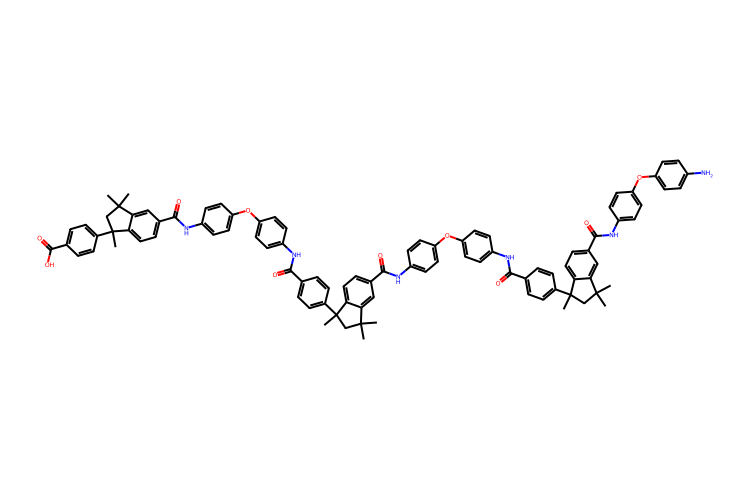

		 workflow_vers
CC1(C)C[C@@](C)(c2ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc6c(c5)C(C)(C)C[C@@]6(C)c5ccc(C(=O)Nc6ccc(Oc7ccc(NC(=O)c8ccc9c(c8)C(C)(C)C[C@]9(C)c8ccc(C(=O)Nc9ccc(Oc%10ccc(N)cc%10)cc9)cc8)cc7)cc6)cc5)cc4)cc3)cc2)c2ccc(C(=O)O)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(Oc4ccc(NC(=O)c5ccc6c(c5)C(C)(C)CC6(C)c5ccc(C(=O)Nc6ccc(Oc7ccc(NC(=O)c8ccc9c(c8)C(C)(C)CC9(C)c8ccc(C(=O)Nc9ccc(Oc%10ccc(N)cc%10)cc9)cc8)cc7)cc6)cc5)cc4)cc3)cc2)c2ccc(C(=O)O)cc21


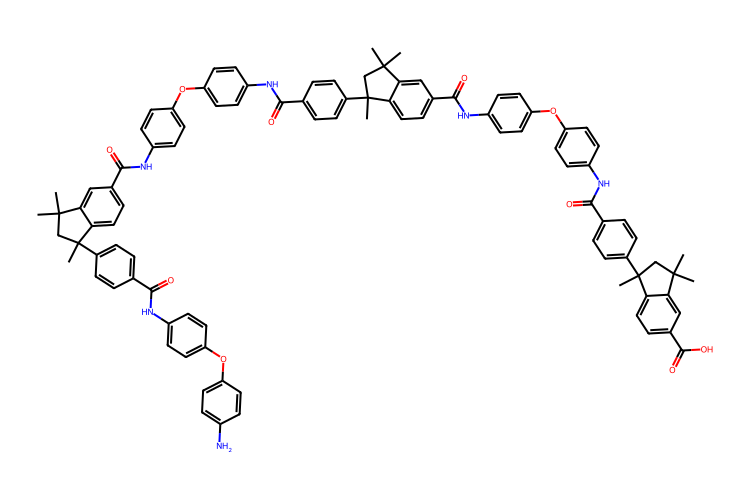

False
	 poly(4-[4-amino-2-(trifluoromethyl)phenyl]-3-(trifluoromethyl)aniline-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2h-indene-5-carboxylic acid)
		 M2P_vers
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(-c4ccc(N)cc4C(F)(F)F)c(C(F)(F)F)c3)cc2)c2ccc(C(=O)Nc3ccc(-c4ccc(NC(=O)c5ccc(C6(C)CC(C)(C)c7cc(C(=O)Nc8ccc(-c9ccc(NC(=O)c%10ccc%11c(c%10)C(C)(C)CC%11(C)c%10ccc(C(=O)O)cc%10)cc9C(F)(F)F)c(C(F)(F)F)c8)ccc76)cc5)cc4C(F)(F)F)c(C(F)(F)F)c3)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(-c4ccc(N)cc4C(F)(F)F)c(C(F)(F)F)c3)cc2)c2ccc(C(=O)Nc3ccc(-c4ccc(NC(=O)c5ccc(C6(C)CC(C)(C)c7cc(C(=O)Nc8ccc(-c9ccc(NC(=O)c%10ccc%11c(c%10)C(C)(C)CC%11(C)c%10ccc(C(=O)O)cc%10)cc9C(F)(F)F)c(C(F)(F)F)c8)ccc76)cc5)cc4C(F)(F)F)c(C(F)(F)F)c3)cc21


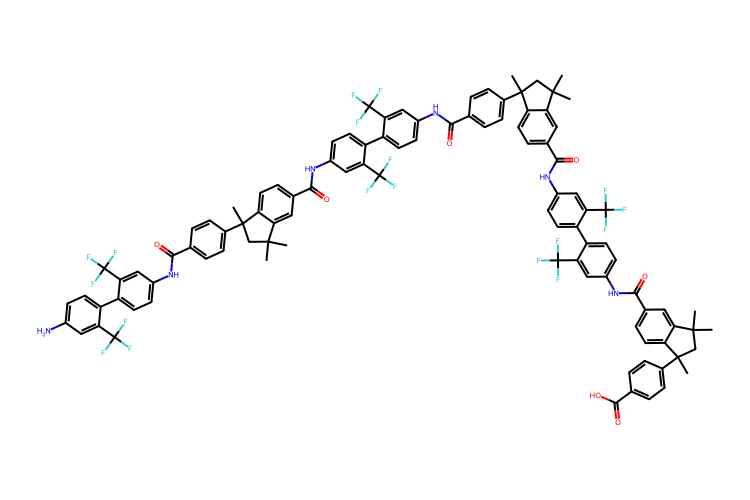

		 workflow_vers
CC1(C)C[C@@](C)(c2ccc(C(=O)Nc3ccc(-c4ccc(NC(=O)c5ccc6c(c5)C(C)(C)C[C@@]6(C)c5ccc(C(=O)Nc6ccc(-c7ccc(NC(=O)c8ccc9c(c8)C(C)(C)C[C@@]9(C)c8ccc(C(=O)Nc9ccc(-c%10ccc(N)cc%10C(F)(F)F)c(C(F)(F)F)c9)cc8)cc7C(F)(F)F)c(C(F)(F)F)c6)cc5)cc4C(F)(F)F)c(C(F)(F)F)c3)cc2)c2ccc(C(=O)O)cc21
CC1(C)CC(C)(c2ccc(C(=O)Nc3ccc(c4ccc(NC(=O)c5ccc6c(c5)C(C)(C)CC6(C)c5ccc(C(=O)Nc6ccc(c7ccc(NC(=O)c8ccc9c(c8)C(C)(C)CC9(C)c8ccc(C(=O)Nc9ccc(c%10ccc(N)cc%10C(F)(F)F)c(C(F)(F)F)c9)cc8)cc7C(F)(F)F)c(C(F)(F)F)c6)cc5)cc4C(F)(F)F)c(C(F)(F)F)c3)cc2)c2ccc(C(=O)O)cc21


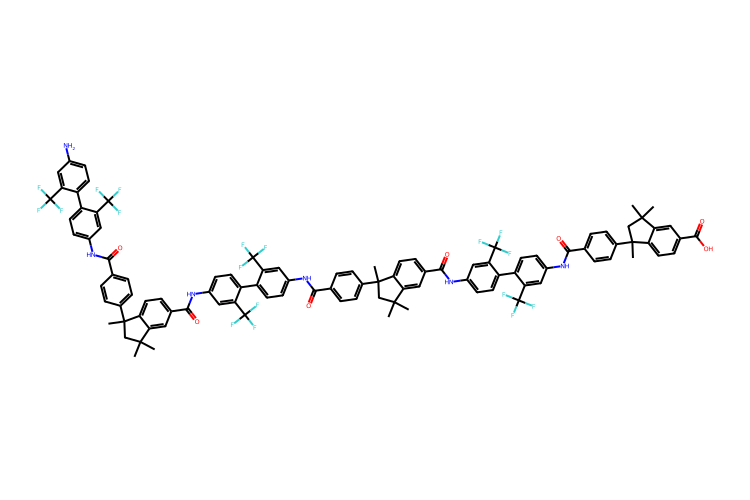

False


In [22]:
from polymerist.rdutils import rdkdraw
rdkdraw.set_rdkdraw_size(500)

for mechanism, mismatch_dict in m2p_mismatches.items():
    print(mechanism)
    for species, smiles_dict in mismatch_dict.items():
        print('\t', species)
        mols = []
        for platform, smiles in smiles_dict.items():
            mol = Chem.MolFromSmiles(smiles, sanitize=False)
            print('\t\t', platform)
            print(Chem.CanonSmiles(smiles))
            Chem.RemoveStereochemistry(mol)
            print(Chem.MolToSmiles(mol))
            display(mol)
            mols.append(mol)
        print(mols[0].HasSubstructMatch(mols[1]))

In [17]:
Chem.RemoveStereochemistry(mol)